In [1]:
# Author : https://github.com/boguss1225
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tqdm import trange

os.environ["CUDA_VISIBLE_DEVICES"]="0"

# Colour Template (RGB)
RED = (255, 0, 0)
DARK_GREEN = (0, 128, 0)
BLUE = (0, 0, 255)
CYAN = (0, 255, 255)
ORANGE = (230,159,0)
GREEN = (0, 255, 0)
NAVY = (0, 0, 128)
MAGENTA = (255, 0, 255)
YELLOW = (255, 255, 0)
PURPLE = (128,0,128)
MID_GREEN = (0,200,0)

2023-01-24 12:04:30.163145: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 12:04:31.031283: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mirap/.local/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-01-24 12:04:31.031366: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mirap/.local/lib/

In [32]:
# TO BE CONFIGURED
PATCH_SIZE_W, PATCH_SIZE_H = 65, 65
FILE_PATH = "/home/mirap/0_DATABASE/outback_veg/1.png"

NUM_CLASSES = 4
IMAGE_SIZE = (125, 125) # w, h
MODEL_SAVE_NAME = "EfficientNetV2B0_4cls"
MODEL_DIR = "../classification-patch-base/trained_models/outback_veg/"+MODEL_SAVE_NAME+"/" # = save_dir

class_colour = {0:RED, 1:DARK_GREEN, 2:BLUE, 3:CYAN, 4:ORANGE, 5:GREEN, 6:NAVY, 7:MAGENTA, 8:YELLOW, 9:PURPLE, 10:MID_GREEN}

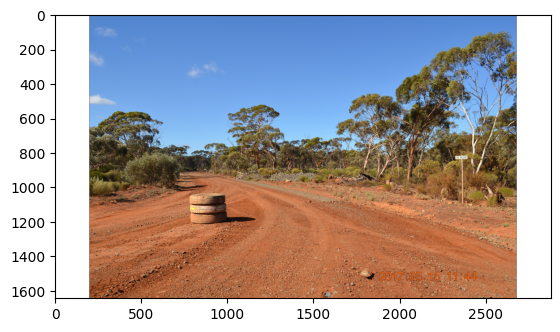

In [33]:
# Check image
img = mpimg.imread(FILE_PATH)
imgplot = plt.imshow(img)
plt.show()

In [34]:
"""
## Load model from h5
"""
model = tf.keras.models.load_model(MODEL_DIR + MODEL_SAVE_NAME + ".h5")
print("load model successful")
# keras.utils.plot_model(model, show_shapes=cTrue)

load model successful


In [35]:
# Load image
im = cv2.imread(FILE_PATH)
im = cv2.cvtColor(im,cv2.COLOR_BGR2RGB)
img_h, img_w, img_c = im.shape

print('width:  ', img_w)
print('height: ', img_h)
print('channel:', img_c)

width:   2880
height:  1644
channel: 3


In [36]:
# Initialize blank mask image of same dimensions for drawing the shapes
bg = np.zeros_like(im, np.uint8)

In [37]:
w_ratio = int(img_w/PATCH_SIZE_W)
h_ratio = int(img_h/PATCH_SIZE_H)

In [38]:
# Prepare for statistics
result_stat = [0] * NUM_CLASSES

In [39]:
def inference(im, model) : 
    im = cv2.resize(im, IMAGE_SIZE)
    img_tensor = tf.convert_to_tensor(im, dtype=tf.float32)
    img_tensor = tf.expand_dims(img_tensor , 0)
#     img_tensor = img_tensor / 255.0 # uncomment if model included rescale preprocessing layer
    prob = model(img_tensor)
    # print(prob)
    classification = np.argmax(prob)

    return classification, prob

In [40]:
def voting_system(cropped_img, model, cent) :
    #┌─┬────┬─┐
    #├─┼────┼─┤
    #│ │┌──┐│ │ 5 voting windows
    #│ │└──┘│ │
    #├─┼────┼─┤
    #└─┴────┴─┘
    piece6_H = int(PATCH_SIZE_H/2) # size 1/6 of cropped image's H
    piece6_W = int(PATCH_SIZE_W/2) # size 1/6 of cropped image's W
    
    big_window = cropped_img
    vert_window = cropped_img[0:6*piece6_H, piece6_W:5*piece6_W]
    hori_window = cropped_img[piece6_H:5*piece6_H, 0:6*piece6_W]
    midi_window = cropped_img[piece6_H:5*piece6_H, piece6_W:5*piece6_W]
    
    foo, big = inference(big_window, model)
    foo, vertical = inference(vert_window, model)
    foo, horizon = inference(hori_window, model)
    foo, mid = inference(midi_window, model)
    
    # Print detail of vote
    print("1 big  10%:", big)
    print("2 vert 10%:", vertical)
    print("3 hori 10%:", horizon)
    print("4 cent 40%:", prob)
    print("5 midi 30%:", mid)
    
    voted_array = ( np.dot(0.1,big) + 
                    np.dot(0.1,vertical) + 
                    np.dot(0.1,horizon) + 
                    np.dot(0.4,cent) + 
                    np.dot(0.3,mid) )
                
    classfication_result = np.argmax(voted_array)
    
    return classfication_result, voted_array


In [41]:
def draw_detection_trace(img, xmin, ymin) :
    thickness = 3
    
    piece6_H = int(PATCH_SIZE_H/2) # size 1/6 of cropped image's H
    piece6_W = int(PATCH_SIZE_W/2) # size 1/6 of cropped image's W
    
    img = cv2.rectangle(img, (xmin,ymin), (xmin+(3*PATCH_SIZE_W),ymin+(3*PATCH_SIZE_H)), GREEN, thickness) # Big
    img = cv2.rectangle(img, (xmin+piece6_W,ymin), (xmin+(5*piece6_W),ymin+(3*PATCH_SIZE_H)), MAGENTA, thickness) # Vertical
    img = cv2.rectangle(img, (xmin,ymin+piece6_H), (xmin+(3*PATCH_SIZE_W),ymin+(5*piece6_H)), CYAN, thickness) # Horizontal
    img = cv2.rectangle(img, (xmin+(PATCH_SIZE_W),ymin+(PATCH_SIZE_H)), (xmin+(2*PATCH_SIZE_W),ymin+(2*PATCH_SIZE_H)), YELLOW, thickness) # Cent
    
    return img
    

In [42]:
THRESHOLD_SCORE = 0.7

detect_map = im.copy()

# iterate image upon patch size
for h in trange(h_ratio) :
    y_min = h * PATCH_SIZE_H
    y_max = y_min + PATCH_SIZE_H
    
    for w in range(w_ratio) : 
        x_min = w * PATCH_SIZE_W
        x_max = x_min + PATCH_SIZE_W
        
        # Cropping image
        cropped_image = im[y_min:y_max,x_min:x_max]
        
        # Classify cropped image
        classfication_result, prob = inference(cropped_image, model)

        if np.max(prob) < THRESHOLD_SCORE :
            try :
                print("voted due to :",np.max(prob),"class:",classfication_result)
                cropped_img = im[y_min-PATCH_SIZE_H:y_max+PATCH_SIZE_H,
                                 x_min-PATCH_SIZE_W:x_max+PATCH_SIZE_W]
                classfication_result, voted_array =  voting_system(cropped_img, model, prob)
                
                print("after vote : ",np.max(voted_array),"class:",classfication_result)
                # trace record
                detect_map = draw_detection_trace(detect_map, x_min-PATCH_SIZE_W, y_min-PATCH_SIZE_H)
            except :
                None

        result_stat[classfication_result] += 1
        # overlay colour on image 
        cv2.rectangle(bg, (x_min, y_min), (x_max, y_max), class_colour[classfication_result] ,cv2.FILLED)

  8%|████▌                                                    | 2/25 [00:08<01:34,  4.09s/it]

voted due to : 0.6996287 class: 0
1 big  10%: tf.Tensor([[0.1631227  0.00856966 0.00290937 0.8253983 ]], shape=(1, 4), dtype=float32)
2 vert 10%: tf.Tensor([[0.1631227  0.00856966 0.00290937 0.8253983 ]], shape=(1, 4), dtype=float32)
3 hori 10%: tf.Tensor([[0.1631227  0.00856966 0.00290937 0.8253983 ]], shape=(1, 4), dtype=float32)
4 cent 40%: tf.Tensor([[0.6996287  0.00078259 0.14956005 0.15002866]], shape=(1, 4), dtype=float32)
5 midi 30%: tf.Tensor([[0.1631227  0.00856966 0.00290937 0.8253983 ]], shape=(1, 4), dtype=float32)
after vote :  0.5552504599094391 class: 3


 80%|████████████████████████████████████████████▊           | 20/25 [01:22<00:20,  4.08s/it]

voted due to : 0.6657317 class: 0
1 big  10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
2 vert 10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
3 hori 10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
4 cent 40%: tf.Tensor([[0.6657317  0.00126587 0.20068438 0.13231799]], shape=(1, 4), dtype=float32)
5 midi 30%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
after vote :  0.6504050672054291 class: 2
voted due to : 0.69168836 class: 0



 84%|███████████████████████████████████████████████         | 21/25 [01:27<00:17,  4.29s/it]

1 big  10%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
2 vert 10%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
3 hori 10%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
4 cent 40%: tf.Tensor([[0.69168836 0.00089259 0.16041602 0.1470031 ]], shape=(1, 4), dtype=float32)
5 midi 30%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
after vote :  0.6969740629196167 class: 0
voted due to : 0.67365795 class: 0
1 big  10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
2 vert 10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
3 hori 10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
4 cent 40%: tf.Tensor([[0.67365795 0.001159   0.18784924 0.13733383]], shape=(1, 4), dtype=float32)
5 midi 30%: tf.Tensor([


 88%|█████████████████████████████████████████████████▎      | 22/25 [01:31<00:13,  4.46s/it]

1 big  10%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
2 vert 10%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
3 hori 10%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
4 cent 40%: tf.Tensor([[0.6989817  0.0007697  0.15460452 0.14564407]], shape=(1, 4), dtype=float32)
5 midi 30%: tf.Tensor([[0.70049787 0.00074604 0.15340237 0.14535375]], shape=(1, 4), dtype=float32)
after vote :  0.6998914003372192 class: 0



 92%|███████████████████████████████████████████████████▌    | 23/25 [01:35<00:08,  4.35s/it]

voted due to : 0.56791055 class: 0
1 big  10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
2 vert 10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
3 hori 10%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
4 cent 40%: tf.Tensor([[0.56791055 0.00257386 0.3392223  0.09029325]], shape=(1, 4), dtype=float32)
5 midi 30%: tf.Tensor([[0.03956904 0.00865313 0.95021886 0.00155898]], shape=(1, 4), dtype=float32)
after vote :  0.7058202385902405 class: 2


100%|████████████████████████████████████████████████████████| 25/25 [01:44<00:00,  4.18s/it]


In [43]:
# Generate output by blending image with bg image, using the bg
# images also as mask to limit the blending to those parts
out = im.copy()
alpha = 0.5 # transparant (highest : 1.0, lowest : 0)
mask = bg.astype(bool)
out[mask] = cv2.addWeighted(im, alpha, bg, 1 - alpha, 0)[mask]

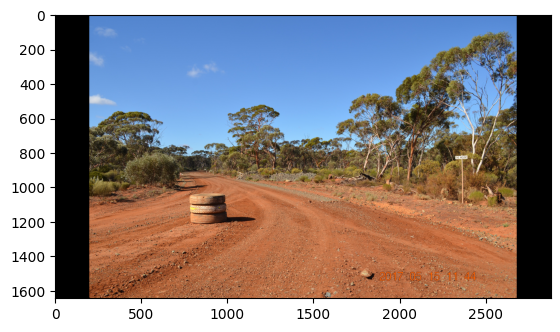

In [44]:
plt.imshow(im)

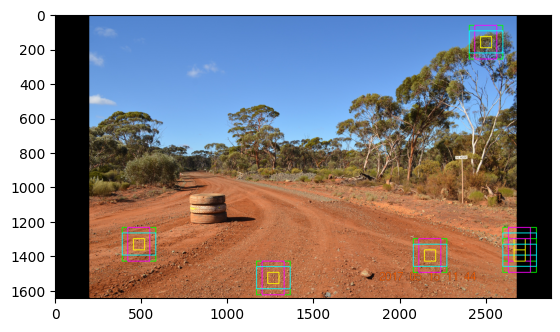

In [45]:
plt.imshow(detect_map)
plt.savefig("result-detect_map_07.png")

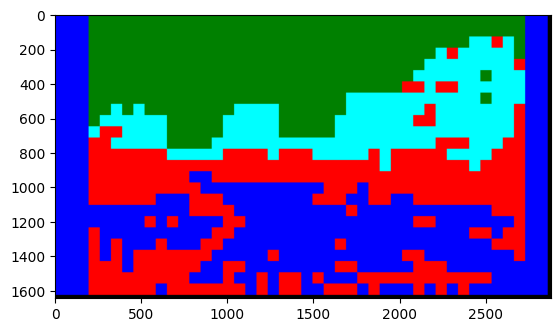

In [46]:
plt.imshow(bg)

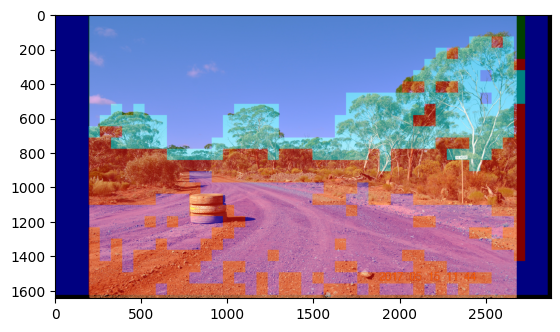

In [47]:
plt.imshow(out)
plt.savefig("result-voting_07.png")

In [27]:
# Create summary table
from tabulate import tabulate

headers = ["item", "qty", "%"]
total = sum(result_stat)
table = []

for i in range(NUM_CLASSES) :
    ele = ["cls_"+str(i+1),result_stat[i],round(result_stat[i]/total,3)*100]
    table.append(ele)

table_str = tabulate(table, headers, tablefmt="fancy_outline")
print(table_str)


╒════════╤═══════╤══════╕
│ item   │   qty │    % │
╞════════╪═══════╪══════╡
│ cls_1  │   447 │ 47.1 │
│ cls_2  │   163 │ 17.2 │
│ cls_3  │    73 │  7.7 │
│ cls_4  │   267 │ 28.1 │
╘════════╧═══════╧══════╛
